In [ ]:
#import packages
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from pydotplus import graph_from_dot_data
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from random import choice
from scipy.stats import ttest_ind
from sklearn.model_selection import KFold 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#this is necessary for reading files from Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read in data
data_MD_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_MD_10-19_xlsx.xlsx')
data_WA_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_WA_10-19_xlsx.xlsx')
data_CT_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_CT_10-19_xlsx.xlsx')
data_FL_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_FL_10-19_xlsx.xlsx')
data_TX_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_TX_10-19_xlsx.xlsx')
data_CO_cause_of_death = pd.read_excel('drive/My Drive/DATA602_project_materials/data/cause_of_death_CO_10-19_xlsx.xlsx')
data_CDC_cause_categories = pd.read_excel('drive/My Drive/DATA602_project_materials/data/CDC_cause_categories.xlsx')
data_income_10_11 = pd.read_excel('drive/My Drive/DATA602_project_materials/data/income_10-11.xlsx',
                                  skiprows=5)
data_income_12_13 = pd.read_excel('drive/My Drive/DATA602_project_materials/data/income_12-13.xlsx',
                                  skiprows=5)
data_income_14_16 = pd.read_excel('drive/My Drive/DATA602_project_materials/data/income_14-16.xlsx',
                                  skiprows=5)
data_income_17_19 = pd.read_excel('drive/My Drive/DATA602_project_materials/data/income_17-19.xlsx',
                                  skiprows=5)
data_deaths = pd.read_excel('drive/My Drive/DATA602_project_materials/data/total_deaths_xlsx.xlsx')
data_air_2010 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2010.csv')
data_air_2011 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2011.csv')
data_air_2012 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2012.csv')
data_air_2013 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2013.csv')
data_air_2014 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2014.csv')
data_air_2015 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2015.csv')
data_air_2016 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2016.csv')
data_air_2017 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2017.csv')
data_air_2018 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2018.csv')
data_air_2019 = pd.read_csv('drive/My Drive/DATA602_project_materials/data/EPA_2019.csv')
data_insurance_2019 = pd.read_excel('drive/My Drive/DATA602_project_materials/data/public_coverage_census.xlsx',
                                    sheet_name='Data')

In [ ]:
#this function takes a dataframe and column name that contains the location name
#returns a state for the columns that are "County, State"
def get_state_col(df, col_name):

  #split the value in the county column and grab the last item 
  #in the resulting list
  state = df[col_name].strip('*').split()[-1]

  return state

#this function takes a dataframe and column name that contains the location name
#returns just the county name for the columns that are "County, State"
def get_county_col(df, col_name):

  #index the string in the county column to grab all
  #but the last 4 positions (", state")
  county = df[col_name].strip('*')[:-4]
  
  return county

In [ ]:
#create a dataframe that combines all states' cause of death data
#but dropping some unnecessary columns
cause_of_death_df = data_MD_cause_of_death.append([data_CT_cause_of_death,
                                                   data_FL_cause_of_death, 
                                                   data_TX_cause_of_death,
                                                   data_WA_cause_of_death,
                                                   data_CO_cause_of_death],
                                                  ignore_index=True)

cause_of_death_df = cause_of_death_df.drop(['Notes', 'Crude Rate', 'Year Code',
                                            'County Code'], axis=1)

#use the get_state_col and get_county_col functions
cause_of_death_df['State'] = cause_of_death_df.apply(lambda x: get_state_col(x, 'County'), axis=1)
cause_of_death_df['County'] = cause_of_death_df.apply(lambda x: get_county_col(x, 'County'), axis=1)
cause_of_death_df.tail()

,County,Year,Cause of death,Cause of death Code,Deaths,Population,State
90054,Weld County,2019,Accidental poisoning by and exposure to antiep...,X41,12,324492,CO
90055,Weld County,2019,Accidental poisoning by and exposure to narcot...,X42,25,324492,CO
90056,Weld County,2019,Accidental poisoning by and exposure to alcohol,X45,13,324492,CO
90057,Weld County,2019,"Intentional self-harm by hanging, strangulatio...",X70,20,324492,CO
90058,Weld County,2019,Intentional self-harm by handgun discharge,X72,28,324492,CO


In [ ]:
#same process for the income dataframes
income_10_11_df = data_income_10_11.drop(['GeoFips', 'LineCode'], axis=1)

income_10_11_df['State'] = income_10_11_df.apply(lambda x: get_state_col(x, 'GeoName'), axis=1)
income_10_11_df['County'] = income_10_11_df.apply(lambda x: get_county_col(x, 'GeoName'), axis=1)
#income_10_11_df.tail()

#same process for the income dataframes
income_12_13_df = data_income_12_13.drop(['GeoFips', 'LineCode'], axis=1)

income_12_13_df['State'] = income_12_13_df.apply(lambda x: get_state_col(x, 'GeoName'), axis=1)
income_12_13_df['County'] = income_12_13_df.apply(lambda x: get_county_col(x, 'GeoName'), axis=1)
#income_12_13_df.tail()

#same process for the income dataframes
income_14_16_df = data_income_14_16.drop(['GeoFips', 'LineCode'], axis=1)

income_14_16_df['State'] = income_14_16_df.apply(lambda x: get_state_col(x, 'GeoName'), axis=1)
income_14_16_df['County'] = income_14_16_df.apply(lambda x: get_county_col(x, 'GeoName'), axis=1)
#income_14_16_df.tail()

#same process for the income dataframes
income_17_19_df = data_income_17_19.drop(['GeoFips', 'LineCode'], axis=1)

income_17_19_df['State'] = income_17_19_df.apply(lambda x: get_state_col(x, 'GeoName'), axis=1)
income_17_19_df['County'] = income_17_19_df.apply(lambda x: get_county_col(x, 'GeoName'), axis=1)
income_17_19_df.tail()

,GeoName,Description,2017,2018,2019,State,County
9409,"Washakie, WY",Population (persons) 1/,8010,7877,7805,WY,Washakie
9410,"Washakie, WY",Per capita personal income (dollars) 2/,45184,49310,50735,WY,Washakie
9411,"Weston, WY",Personal income (thousands of dollars),296021,311165,323176,WY,Weston
9412,"Weston, WY",Population (persons) 1/,6968,6924,6927,WY,Weston
9413,"Weston, WY",Per capita personal income (dollars) 2/,42483,44940,46655,WY,Weston


In [ ]:
#the values in the "Description" column in the income dataframes should
#be columns and the years should be row values
#this function uses the melt function to do that
#it takes the dataframe and a list of the years that are column names that
#we want to be in the rows
def melt_income_df(df, value_vars_list):

  new_df = df.melt(id_vars=['County', 'State', 'Description'],
                                             value_vars=value_vars_list, 
                                             var_name='Year')
  
  return new_df

In [ ]:
#use the melt_income_df function to switch the columns and rows
income_10_11_pivot_df = melt_income_df(income_10_11_df, ['2010','2011'])
#income_10_11_pivot_df.tail()

#follow the same process for all income dataframes
income_12_13_pivot_df = melt_income_df(income_12_13_df, ['2012','2013'])
income_14_16_pivot_df = melt_income_df(income_14_16_df, ['2014','2015','2016'])
income_17_19_pivot_df = melt_income_df(income_17_19_df, ['2017','2018','2019'])

#append the income dataframes together
income_df = income_10_11_pivot_df.append(income_12_13_pivot_df)
income_df = income_df.append(income_14_16_pivot_df)
income_df = income_df.append(income_17_19_pivot_df)

In [ ]:
#strip some extra characters from description column
income_df['Description'] = income_df['Description'].str.strip('12/ ')

#drop some rows with extra info
income_df = income_df.loc[(income_df['Description'] != 'Personal income (thousands of dollars)') &
                          (income_df['Description'] != 'Population (persons)')]

#rename "value" column to something more descriptive
income_df = income_df.rename(columns={'value':'per_capita_income_dollars'}).drop('Description', axis=1)

#make county names consistent with MD death dataframe
income_df['County'] = income_df['County'] + ' County'
income_df.loc[income_df['County'] == 
              'Baltimore (Independent City) County','County'] = 'Baltimore city'

income_df.head()

,County,State,Year,per_capita_income_dollars
2,Autauga County,AL,2010,33348
5,Baldwin County,AL,2010,36143
8,Barbour County,AL,2010,27770
11,Bibb County,AL,2010,25057
14,Blount County,AL,2010,27701


In [ ]:
#drop unnecessary columns
deaths_df = data_deaths.drop(['Year Code', 'Crude Rate'], axis=1)

#get county and state columns
deaths_df['State'] = deaths_df.apply(lambda x: get_state_col(x, 'County'), axis=1)
deaths_df['County'] = deaths_df.apply(lambda x: get_county_col(x, 'County'), axis=1)

#rename "Deaths" column to "Total Deaths"
deaths_df = deaths_df.rename(columns={'Deaths':'Total Deaths'})

#deaths_df.tail()

In [ ]:
#remove the decimal from cause of death code so this column can be linked
#to the more-general cause of death categories from CDC
def get_cause_code(df):
  new_code = df['Cause of death Code'][:3]
  return new_code

cause_of_death_df['Cause of death Code no decimal'] = cause_of_death_df.apply(lambda x: get_cause_code(x), 
                                                      axis=1)

#cause_of_death_df.tail()

In [ ]:
#add year column to all air data frames and then append them 

data_air_2010['Year'] = '2010'
data_air_2011['Year'] = '2011'
data_air_2012['Year'] = '2012'
data_air_2013['Year'] = '2013'
data_air_2014['Year'] = '2014'
data_air_2015['Year'] = '2015'
data_air_2016['Year'] = '2016'
data_air_2017['Year'] = '2017'
data_air_2018['Year'] = '2018'
data_air_2019['Year'] = '2019'

air_df = data_air_2010.append([data_air_2011, data_air_2012, data_air_2013,
                               data_air_2014, data_air_2015, data_air_2016,
                               data_air_2017, data_air_2018, data_air_2019], 
                              ignore_index=True)

#get county and state columns in air_df
air_df['State'] = air_df.apply(lambda x: get_state_col(x, 'County'), axis=1)
air_df['County'] = air_df.apply(lambda x: get_county_col(x, 'County'), axis=1)
#air_df.head()

#make county names consistent with MD death dataframe
air_df.loc[air_df['County'] == 'Baltimore (City)','County'] = 'Baltimore city'

#replace '.' with np.nan
air_df = air_df.replace('.', np.nan)
air_df.head()

,County Code,County,CO 2nd Max 1-hr,CO 2nd Max 8-hr,NO2 98th Percentile 1-hr,NO2 Mean 1-hr,Ozone 2nd Max 1-hr,Ozone 4th Max 8-hr,SO2 99th Percentile 1-hr,SO2 2nd Max 24-hr,SO2 Mean 1-hr,PM2.5 98th Percentile 24-hr,PM2.5 Weighted Mean 24-hr,PM10 2nd Max 24-hr,PM10 Mean 24-hr,Lead Max 3-Mo Avg,Year,State
0,1003,Baldwin County,NaN,NaN,NaN,NaN,0.09,0.074,NaN,NaN,NaN,20,10.2,NaN,NaN,NaN,2010,AL
1,1027,Clay County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,10.5,NaN,NaN,NaN,2010,AL
2,1033,Colbert County,NaN,NaN,NaN,NaN,0.08,0.068,NaN,NaN,NaN,22,11.1,NaN,NaN,NaN,2010,AL
3,1049,DeKalb County,NaN,NaN,NaN,NaN,0.08,0.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,AL
4,1051,Elmore County,NaN,NaN,NaN,NaN,0.08,0.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,AL


In [ ]:
#this is too many NaNs to ignore, neeed to come up with an imputation method
air_df['Ozone 2nd Max 1-hr'].isnull().sum()/air_df.shape[0]

#20% missing is too many to drop
#will fill missing with average by state

0.19977192618702053

In [ ]:
air_df['PM2.5 98th Percentile 24-hr'].isnull().sum()/air_df.shape[0]

0.47242380261248185

In [ ]:
cause_of_death_df['Year'] = cause_of_death_df['Year'].astype('str')
deaths_df['Year'] = deaths_df['Year'].astype('str')
cause_of_death_df = cause_of_death_df.merge(deaths_df[['County', 'Year', 'Total Deaths', 'State']], 
                                            on=['County', 'State', 'Year'])
cause_of_death_df = cause_of_death_df.merge(income_df, on=['County', 'State', 'Year'])
#cause_of_death_df.tail()

cause_of_death_df = cause_of_death_df.merge(data_CDC_cause_categories, 
                                            left_on='Cause of death Code no decimal',
                                            right_on = 'Code')
#cause_of_death_df.head()

cause_of_death_df = cause_of_death_df.merge(air_df[['Year', 'County', 'State', 'Ozone 2nd Max 1-hr']], 
                                            left_on=['County', 'State', 'Year'],
                                            right_on=['County', 'State', 'Year'],
                                            how = 'left')
cause_of_death_df.head()

,County,Year,Cause of death,Cause of death Code,Deaths,Population,State,Cause of death Code no decimal,Total Deaths,per_capita_income_dollars,Code,Category,Ozone 2nd Max 1-hr
0,Allegany County,2013,Atherosclerotic heart disease,I25.1,125,73521,MD,I25,946,34504,I25,Diseases of the circulatory system,NaN
1,Allegany County,2013,"Atherosclerotic cardiovascular disease, so des...",I25.0,50,73521,MD,I25,946,34504,I25,Diseases of the circulatory system,NaN
2,Allegany County,2010,Atherosclerotic heart disease,I25.1,119,75087,MD,I25,913,32000,I25,Diseases of the circulatory system,NaN
3,Allegany County,2010,"Atherosclerotic cardiovascular disease, so des...",I25.0,32,75087,MD,I25,913,32000,I25,Diseases of the circulatory system,NaN
4,Allegany County,2014,Atherosclerotic heart disease,I25.1,105,72952,MD,I25,910,35800,I25,Diseases of the circulatory system,NaN


In [ ]:
cause_of_death_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90059 entries, 0 to 90058
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   County                          90059 non-null  object
 1   Year                            90059 non-null  object
 2   Cause of death                  90059 non-null  object
 3   Cause of death Code             90059 non-null  object
 4   Deaths                          90059 non-null  int64 
 5   Population                      90059 non-null  int64 
 6   State                           90059 non-null  object
 7   Cause of death Code no decimal  90059 non-null  object
 8   Total Deaths                    90059 non-null  object
 9   per_capita_income_dollars       90059 non-null  object
 10  Code                            90059 non-null  object
 11  Category                        90059 non-null  object
 12  Ozone 2nd Max 1-hr              69584 non-null

In [ ]:
cause_of_death_df = cause_of_death_df.sort_values(by='State')
cause_of_death_df['Ozone 2nd Max 1-hr'] = cause_of_death_df['Ozone 2nd Max 1-hr'].ffill().bfill()
#cause_of_death_df.head()

In [ ]:
cause_of_death_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90059 entries, 24357 to 90058
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   County                          90059 non-null  object
 1   Year                            90059 non-null  object
 2   Cause of death                  90059 non-null  object
 3   Cause of death Code             90059 non-null  object
 4   Deaths                          90059 non-null  int64 
 5   Population                      90059 non-null  int64 
 6   State                           90059 non-null  object
 7   Cause of death Code no decimal  90059 non-null  object
 8   Total Deaths                    90059 non-null  object
 9   per_capita_income_dollars       90059 non-null  object
 10  Code                            90059 non-null  object
 11  Category                        90059 non-null  object
 12  Ozone 2nd Max 1-hr              90059 non-

In [ ]:
cause_of_death_df = cause_of_death_df.astype({'per_capita_income_dollars': 'float', 
                                              'Ozone 2nd Max 1-hr': 'float'})

avg_by_county = cause_of_death_df.groupby('County', as_index=True)[['County', 
                                                                    'per_capita_income_dollars', 
                                                                    'Ozone 2nd Max 1-hr', 
                                                                    'Deaths']].mean().reset_index()

In [ ]:
avg_death_by_county = cause_of_death_df[['County', 'Cause of death', 'Category', 'Deaths']].groupby(['County',
                                                                                                     'Cause of death',
                                                                                                     'Category']).aggregate(np.mean).reset_index()

In [ ]:
avg_by_county.head()

,County,per_capita_income_dollars,Ozone 2nd Max 1-hr,Deaths
0,Adams County,38125.385938,0.085609,30.292188
1,Alachua County,41283.182674,0.073879,27.487759
2,Alamosa County,34133.375000,0.090000,12.750000
3,Allegany County,36622.478495,0.090484,28.435484
4,Anderson County,30363.732143,0.093750,21.008929


In [ ]:

avg_death_by_county.head()

,County,Cause of death,Category,Deaths
0,Adams County,Accidental poisoning by and exposure to alcohol,Other external causes of accidental injury,13.000000
1,Adams County,Accidental poisoning by and exposure to antiep...,Other external causes of accidental injury,12.714286
2,Adams County,Accidental poisoning by and exposure to narcot...,Other external causes of accidental injury,37.700000
3,Adams County,Accidental poisoning by and exposure to other ...,Other external causes of accidental injury,26.000000
4,Adams County,Acute myeloid leukaemia - Malignant neoplasms,Neoplasms,12.200000


In [ ]:
#avg_death_by_county.loc[avg_death_by_county['Category'] == 'Diseases of the respiratory system']['Cause of death'].unique()

In [ ]:
def respiratory(df):
  if df['Category'] == 'Diseases of the respiratory system':
    respiratory = 'yes'
  elif df['Cause of death'] == 'Bronchus or lung, unspecified - Malignant neoplasms':
    respiratory = 'yes'
  else:
    respiratory = 'no'
  return respiratory

avg_death_by_county['respiratory'] = avg_death_by_county.apply(lambda x: respiratory(x), axis=1)

In [ ]:
avg_death_by_county.head()

,County,Cause of death,Category,Deaths,respiratory
0,Adams County,Accidental poisoning by and exposure to alcohol,Other external causes of accidental injury,13.000000,no
1,Adams County,Accidental poisoning by and exposure to antiep...,Other external causes of accidental injury,12.714286,no
2,Adams County,Accidental poisoning by and exposure to narcot...,Other external causes of accidental injury,37.700000,no
3,Adams County,Accidental poisoning by and exposure to other ...,Other external causes of accidental injury,26.000000,no
4,Adams County,Acute myeloid leukaemia - Malignant neoplasms,Neoplasms,12.200000,no


In [ ]:
avg_income = avg_by_county['per_capita_income_dollars'].mean()
stdev_income = avg_by_county['per_capita_income_dollars'].std()
stdev_minus3_income = avg_income - 3*(stdev_income)
stdev_plus3_income = avg_income + 3*(stdev_income)
min_income = avg_by_county['per_capita_income_dollars'].min()
max_income = avg_by_county['per_capita_income_dollars'].max()

print('Average: ',avg_income)
print('Standard dev: ', stdev_income)
print('Min: ', min_income)
print('Max: ', max_income)
print('Mean minus 3 st. dev.s: ', stdev_minus3_income)
print('Mean plut 3 st. dev.s: ', stdev_plus3_income)

Average:  41088.67469332886
Standard dev:  11460.479542133588
Min:  16216.0
Max:  107553.32766761095
Mean minus 3 st. dev.s:  6707.236066928097
Mean plut 3 st. dev.s:  75470.11331972963


(array([ 10.,  85., 145.,  63.,  24.,   9.,   6.,   2.,   0.,   2.]),
 array([ 16216.        ,  25349.73276676,  34483.46553352,  43617.19830028,
         52750.93106704,  61884.66383381,  71018.39660057,  80152.12936733,
         89285.86213409,  98419.59490085, 107553.32766761]),
 <a list of 10 Patch objects>)

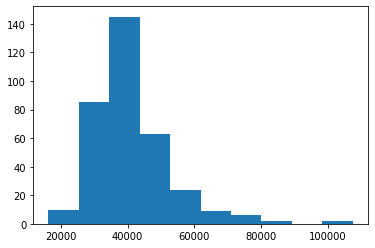

In [ ]:
plt.hist(avg_by_county['per_capita_income_dollars'])

In [ ]:
#create and empty dictionary and lists to hold the info from our for loop
common_cause_dict = {}
county_list = []
cause_list = []
category_list = []

#loop over every county
for county in avg_death_by_county['County'].unique():

  #get the index location of the cause of death that has the highest number
  #of deaths for each county
  common_index = avg_death_by_county.loc[avg_death_by_county['County'] == county]['Deaths'].idxmax()

  #get the cause associated with that index
  cause = avg_death_by_county.loc[[common_index]]['Cause of death'].values[0]
  category = avg_death_by_county.loc[[common_index]]['Category'].values[0]
  
  #append these to lists
  county_list.append(county)
  cause_list.append(cause)
  category_list.append(category)

#assign the lists to dictionary keys to become a DF
common_cause_dict['County'] = county_list
common_cause_dict['Cause of death'] = cause_list
common_cause_dict['Category'] = category_list

In [ ]:
common_cause_df = pd.DataFrame.from_dict(data=common_cause_dict)
common_cause_df['respiratory'] = common_cause_df.apply(lambda x: respiratory(x), axis=1)
common_cause_df.head()

,County,Cause of death,Category,respiratory
0,Adams County,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,yes
1,Alachua County,Unspecified dementia,Mental and behavioral disorders,no
2,Alamosa County,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,yes
3,Allegany County,Atherosclerotic heart disease,Diseases of the circulatory system,no
4,Anderson County,"Bronchus or lung, unspecified - Malignant neop...",Neoplasms,yes


In [ ]:
avg_by_county = avg_by_county.merge(common_cause_df, on='County')
avg_by_county.head()

,County,per_capita_income_dollars,Ozone 2nd Max 1-hr,Deaths,Cause of death,Category,respiratory
0,Adams County,38125.385938,0.085609,30.292188,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,yes
1,Alachua County,41283.182674,0.073879,27.487759,Unspecified dementia,Mental and behavioral disorders,no
2,Alamosa County,34133.375000,0.090000,12.750000,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,yes
3,Allegany County,36622.478495,0.090484,28.435484,Atherosclerotic heart disease,Diseases of the circulatory system,no
4,Anderson County,30363.732143,0.093750,21.008929,"Bronchus or lung, unspecified - Malignant neop...",Neoplasms,yes


In [ ]:
X = avg_by_county[['Ozone 2nd Max 1-hr', 'per_capita_income_dollars']]
y = avg_by_county[['respiratory']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=1)

In [ ]:
model = tree.DecisionTreeClassifier(random_state=1, max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_pred_train))
print('test accuracy: ', accuracy_score(y_test, y_pred_test))

train accuracy:  0.7231404958677686
test accuracy:  0.7307692307692307


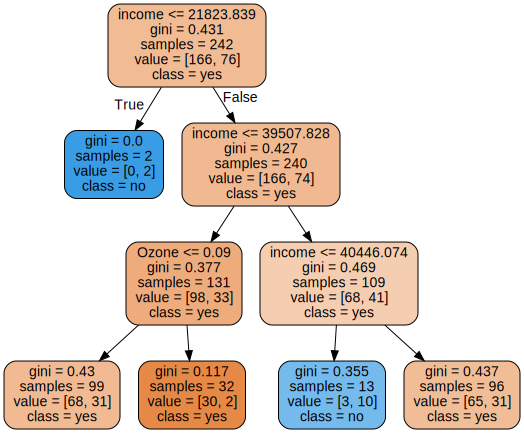

In [ ]:
dot_data = tree.export_graphviz(model, filled=True, rounded=True,
                                feature_names=['Ozone','income'],
                                class_names=y['respiratory'],
                                    out_file=None)
graph = graphviz.Source(dot_data, format="png") 
graph

In [ ]:
model.feature_importances_

array([0.26805832, 0.73194168])

In [ ]:
forest = RandomForestClassifier(criterion = 'gini', n_estimators=1000,
                                random_state=1, n_jobs=2)
forest.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print('train accuracy: ', accuracy_score(y_train, y_pred_train))
print('test accuracy: ', accuracy_score(y_test, y_pred_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


train accuracy:  0.7231404958677686
test accuracy:  0.7307692307692307


In [ ]:
## metrics for DT

In [ ]:
from sklearn import metrics
y_pred=model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


0.7307692307692307
              precision    recall  f1-score   support

          no       0.74      0.99      0.84        76
         yes       0.50      0.04      0.07        28

    accuracy                           0.73       104
   macro avg       0.62      0.51      0.45       104
weighted avg       0.67      0.73      0.63       104



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[75  1]
 [27  1]]


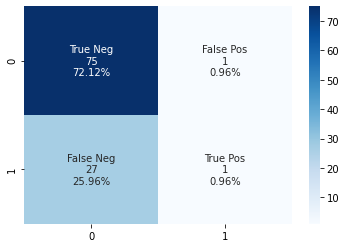

In [ ]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
### Metrics for Random forest

In [ ]:
from sklearn import metrics
y_pred=model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

0.7307692307692307
              precision    recall  f1-score   support

          no       0.74      0.99      0.84        76
         yes       0.50      0.04      0.07        28

    accuracy                           0.73       104
   macro avg       0.62      0.51      0.45       104
weighted avg       0.67      0.73      0.63       104



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[75  1]
 [27  1]]


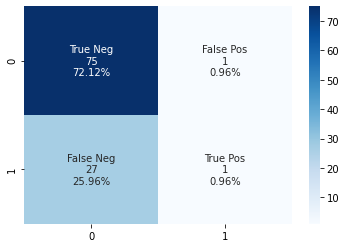

In [ ]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
param_dict={ "criterion":["gini","entropy"],
            "max_depth":range(1,10),
            "min_samples_split":range(1,10),
            "min_samples_leaf":range(1,5)}

grid=GridSearchCV(model,param_grid=param_dict,cv=10,verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2730 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:   43.0s finished


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [ ]:
grid.best_score_

0.7193333333333334

In [ ]:
X.shape

(346, 2)

In [ ]:
#create random yes/no data 
y_random = []
for i in range(0,346):
  respiratory_choice = choice(['yes', 'no'])
  y_random.append(respiratory_choice)

y_random = pd.DataFrame(y_random)

In [ ]:
y_random.head()

,0
0,yes
1,no
2,yes
3,no
4,no


In [ ]:
kf = KFold(n_splits=10, random_state=1)
 
acc_score = []
acc_score_random = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index,:] , y.iloc[test_index,:]
    y_random_test = y_random.iloc[test_index,:]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_random = accuracy_score(y_random_test, y_test)
    acc_score.append(acc)
    acc_score_random.append(acc_random)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
acc_score

[0.5428571428571428,
 0.6285714285714286,
 0.6857142857142857,
 0.7428571428571429,
 0.8,
 0.8571428571428571,
 0.7058823529411765,
 0.5294117647058824,
 0.7941176470588235,
 0.7058823529411765]

In [ ]:
acc_score_random

[0.5428571428571428,
 0.45714285714285713,
 0.6571428571428571,
 0.5714285714285714,
 0.6,
 0.4,
 0.5,
 0.6470588235294118,
 0.5,
 0.5]

In [ ]:
stat, p = ttest_ind(acc_score, acc_score_random)
print('t-statistic = ', stat, 'p-value = ', p)

print('DT accuracy score mean: ', np.mean(acc_score))
print('Random model accuracy score mean: ', np.mean(acc_score_random))


t-statistic =  3.769900760680446 p-value =  0.001402362944676957
DT accuracy score mean:  0.6992436974789916
Random model accuracy score mean:  0.537563025210084


In [ ]:
print('null hyp: The decision tree model with income and ozone as inputs is not better than a random chance model \n at predicting whether the most common cause of death in a county is respiratory related.')
print('alt hyp: The decision tree model with income and ozone as inputs is better than a random chance model  \n at predicting whether the most common cause of death in a county is respiratory related.')

if p > 0.05:
  print('We fail to reject the null hypothesis')
else:
  print('We reject the null hypothesis')

null hyp: The decision tree model with income and ozone as inputs is not better than a random chance model 
 at predicting whether the most common cause of death in a county is respiratory related.
alt hyp: The decision tree model with income and ozone as inputs is better than a random chance model  
 at predicting whether the most common cause of death in a county is respiratory related.
We reject the null hypothesis


In [ ]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [ ]:
from sklearn import metrics
y_pred=model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

0.7058823529411765
              precision    recall  f1-score   support

          no       0.71      1.00      0.83        24
         yes       0.00      0.00      0.00        10

    accuracy                           0.71        34
   macro avg       0.35      0.50      0.41        34
weighted avg       0.50      0.71      0.58        34



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[24  0]
 [10  0]]


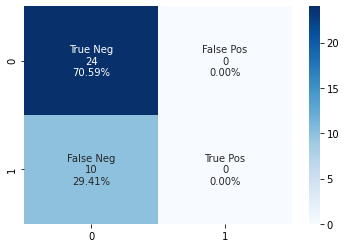

In [ ]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
!pip install lazypredict
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
 14%|█▍        | 4/29 [00:00<00:01, 16.31it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for BaggingClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for BernoulliNB
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for CalibratedClassifierCV
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for DummyClassifier
could not convert string to float: 'no'


 31%|███       | 9/29 [00:00<00:01, 18.72it/s]

ROC AUC couldn't be calculated for ExtraTreeClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for ExtraTreesClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for GaussianNB
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')


 55%|█████▌    | 16/29 [00:00<00:00, 23.75it/s]

ROC AUC couldn't be calculated for KNeighborsClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for LabelPropagation
could not convert string to float: 'no'
ROC AUC couldn't be calculated for LabelSpreading
could not convert string to float: 'no'
ROC AUC couldn't be calculated for LinearDiscriminantAnalysis
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for LinearSVC
could not convert string to float: 'no'
ROC AUC couldn't be calculated for LogisticRegression
could not convert string to float: 'no'
ROC AUC couldn't be calculated for NearestCentroid
could not convert string to float: 'yes'


 69%|██████▉   | 20/29 [00:00<00:00, 27.62it/s]

ROC AUC couldn't be calculated for NuSVC
could not convert string to float: 'no'
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for Perceptron
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for QuadraticDiscriminantAnalysis
could not convert string to float: 'no'


 97%|█████████▋| 28/29 [00:01<00:00, 23.54it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
could not convert string to float: 'no'
ROC AUC couldn't be calculated for RidgeClassifier
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for RidgeClassifierCV
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for SGDClassifier
ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> dtype('<U3')
ROC AUC couldn't be calculated for SVC
could not convert string to float: 'no'
StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'
ROC AUC couldn't be calculated for XGBClassifier
could not convert string to float: 'no'


100%|██████████| 29/29 [00:01<00:00, 21.91it/s]

ROC AUC couldn't be calculated for LGBMClassifier
could not convert string to float: 'no'


In [ ]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
BaggingClassifier,0.68,0.60,None,0.67,0.05
NuSVC,0.65,0.57,None,0.65,0.04
SGDClassifier,0.56,0.54,None,0.58,0.02
AdaBoostClassifier,0.68,0.51,None,0.61,0.12
LGBMClassifier,0.68,0.51,None,0.61,0.06
DecisionTreeClassifier,0.59,0.50,None,0.59,0.02
CalibratedClassifierCV,0.71,0.50,None,0.58,0.07
SVC,0.71,0.50,None,0.58,0.02
BernoulliNB,0.71,0.50,None,0.58,0.02


In [ ]:
avg_by_county['respiratory']=avg_by_county['respiratory'].map({'no':0, 'yes':1})
avg_by_county['respiratory']=avg_by_county['respiratory'].astype(float)

In [ ]:
avg_by_county

,County,per_capita_income_dollars,Ozone 2nd Max 1-hr,Deaths,Cause of death,Category,respiratory
0,Adams County,38125.39,0.09,30.29,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,1.00
1,Alachua County,41283.18,0.07,27.49,Unspecified dementia,Mental and behavioral disorders,0.00
2,Alamosa County,34133.38,0.09,12.75,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,1.00
3,Allegany County,36622.48,0.09,28.44,Atherosclerotic heart disease,Diseases of the circulatory system,0.00
4,Anderson County,30363.73,0.09,21.01,"Bronchus or lung, unspecified - Malignant neop...",Neoplasms,1.00
...,...,...,...,...,...,...,...
341,Yakima County,39095.99,0.07,30.24,"Acute myocardial infarction, unspecified",Diseases of the circulatory system,0.00
342,Young County,48335.96,0.10,15.94,Atherosclerotic heart disease,Diseases of the circulatory system,0.00
343,Yuma County,47185.20,0.08,10.40,"Chronic obstructive pulmonary disease, unspeci...",Diseases of the respiratory system,1.00
344,Zapata County,28844.62,0.08,13.88,Other ill-defined and unspecified causes of mo...,"Symptoms, signs and abnormal clinical and labo...",0.00


In [ ]:
## Training by Neural Network

In [ ]:
X = avg_by_county[['Ozone 2nd Max 1-hr', 'per_capita_income_dollars']]
y = avg_by_county[['respiratory']]
import tensorflow as tf
m1 = tf.keras.models.Sequential([
tf.keras.layers.Dense(32,activation=tf.nn.relu),# creating 32 nuerons and applying actv func at hd layer as relu
tf.keras.layers.Dense(16,activation=tf.nn.relu),
tf.keras.layers.Dense(1,activation=tf.nn.relu)
])

In [ ]:
optimiser = tf.keras.optimizers.Adam()
m1.compile (optimizer= optimiser, loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
avg_by_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346 entries, 0 to 345
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   County                     346 non-null    object 
 1   per_capita_income_dollars  346 non-null    float64
 2   Ozone 2nd Max 1-hr         346 non-null    float64
 3   Deaths                     346 non-null    float64
 4   Cause of death             346 non-null    object 
 5   Category                   346 non-null    object 
 6   respiratory                346 non-null    float64
dtypes: float64(4), object(3)
memory usage: 31.6+ KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=1)


In [ ]:
m1.fit(X_train,y_train,epochs=100) #Running for 100 epochs

Epoch 1/100
8/8 [==============================] - 1s 2ms/step - loss: 4.9783 - accuracy: 0.6773
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8408 - accuracy: 0.6862
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 4.6671 - accuracy: 0.6974
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0233 - accuracy: 0.6743
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7567 - accuracy: 0.6916
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 5.4966 - accuracy: 0.6437
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 5.0461 - accuracy: 0.6729
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 4.7969 - accuracy: 0.6890
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 5.1352 - accuracy: 0.6671
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 4.8594 - accuracy: 0.6850
Epoch 11/100
8/8 [===========